In [2]:
import os
import keras
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
SEED       = 68857869
BATCH_SIZE = 32
IMG_WIDTH  = 64
IMG_HEIGHT = 64
BETA       = 0.9

random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Dataset Download and Preparation

In [4]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip
!mkdir images
!find tiny-imagenet-200 -type f -name '*.JPEG' -exec mv {} images \;
!ls images | wc -l
!mkdir -p cache

--2024-08-27 00:54:39--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-08-27 00:54:40--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  6.02MB/s    in 51s     

2024-08-27 00:55:33 (4.68 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

Archive:  tiny-imagenet-200.zip
   creating: tiny-imagenet-200/
  inflating: tiny-imagenet-200/words.txt  
  inflating: tiny-imagenet-200/wnids.txt  
   creating: tiny-imagenet-200

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_86.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_405.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_275.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_192.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_453.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_58.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_114.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_199.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_206.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_260.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_22.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_3.JPEG  
  inflating: tiny-imagenet-200/train/n04540053/images/n04540053_9.JPEG  
  inflating: tiny-imagenet-200/

### Data Loading and Preprocessing

In [5]:
def decode_img(img,img_width,img_height):
  img = tf.io.read_file(img)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [img_width,img_height])
  return img/255.0


def datapipe(files,batch_size,img_width,img_height,name):
  cover = tf.data.Dataset.from_tensor_slices(files)
  cover = cover.map(lambda x: decode_img(x,img_width,img_height))

  random.shuffle(files)

  payload = tf.data.Dataset.from_tensor_slices(files)
  payload = payload.map(lambda x: decode_img(x,img_width,img_height))

  data = tf.data.Dataset.zip(cover,payload)
  ds = tf.data.Dataset.zip(data,data)

  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

files       = [f"images/{_file}" for _file in os.listdir('images')]
train , val = train_test_split(files,train_size=0.7)

batch_size=32

train_dataset = datapipe(train,batch_size,64,64,'train')
val_dataset   = datapipe(val,batch_size,64,64,'val')

float32 1.0 0.0


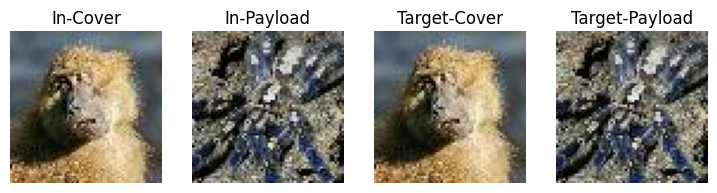

float32 1.0 0.0


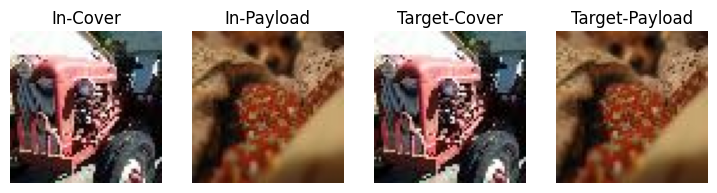

In [7]:
for target,predict in train_dataset.take(2):
    cover = target[0][0].numpy()
    payload = target[1][0].numpy()

    print(cover.dtype,cover.max(),cover.min())
    
    fig, ax = plt.subplots(1, 4, figsize=(9, 5))

    ax[0].imshow(cover)
    ax[0].set_title('In-Cover')
    ax[0].axis('off')

    ax[1].imshow(payload)
    ax[1].set_title('In-Payload')
    ax[1].axis('off')

    cover = predict[0][0].numpy()
    payload = predict[1][0].numpy()

    ax[2].imshow(cover)
    ax[2].set_title('Target-Cover')
    ax[2].axis('off')

    ax[3].imshow(payload)
    ax[3].set_title('Target-Payload')
    ax[3].axis('off')

    plt.show()

### Model Definition

In [8]:
def conv_layer(x, num_filters, activation='relu', name='conv_layer'):
    x = keras.layers.Conv2D(num_filters, (3, 3), padding='same', name=f'{name}_conv')(x)
    x = keras.layers.BatchNormalization(name=f'{name}_bn')(x)
    x = keras.layers.Activation(activation, name=f'{name}_act')(x)
    return x

def encoder():
    cover_input = keras.Input(shape=(64, 64, 3), name='cover_input')
    payload_input = keras.Input(shape=(64, 64, 3), name='payload_input')

    conc_layer = keras.layers.Concatenate(name='concat_cover_payload')([cover_input, payload_input])

    l1 = conv_layer(conc_layer, 64, name='encoder_l1')
    l2 = conv_layer(l1, 128, name='encoder_l2')
    l3 = conv_layer(l2, 256, name='encoder_l3')
    l4 = conv_layer(l3, 512, name='encoder_l4')
    l5 = conv_layer(l4, 512, name='encoder_l5')

    x = keras.layers.Concatenate(name='concat_l3_l5')([l3, l5])
    l6 = conv_layer(x, 256, name='encoder_l6')

    x = keras.layers.Concatenate(name='concat_l2_l6')([l2, l6])
    l7 = conv_layer(x, 128, name='encoder_l7')

    x = keras.layers.Concatenate(name='concat_l1_l7')([l1, l7])
    l8 = conv_layer(x, 64, name='encoder_l8')

    steg_image = conv_layer(l8, 3, activation='sigmoid', name='encoder_output')

    encoder_model = keras.Model(inputs=[cover_input, payload_input], outputs=steg_image, name='encoder')
    return encoder_model

def decoder():
    steg_input = keras.layers.Input(shape=(64, 64, 3), name='steg_image_input')
    x = conv_layer(steg_input, 64, name='decoder_l1')
    x = conv_layer(x, 128, name='decoder_l2')
    x = conv_layer(x, 256, name='decoder_l3')
    x = conv_layer(x, 128, name='decoder_l4')
    x = conv_layer(x, 64, name='decoder_l5')
    x = conv_layer(x, 3, activation='sigmoid', name='decoder_output')

    decoder_model = keras.Model(inputs=steg_input, outputs=x, name='decoder')
    return decoder_model

In [9]:
cover_input = keras.Input(shape=(64, 64, 3), name='cover_input')
payload_input = keras.Input(shape=(64, 64, 3), name='payload_input')

encoder_model = encoder()
decoder_model = decoder()

steg_image    = encoder_model([cover_input, payload_input])
payload_image = decoder_model(steg_image)

model = keras.Model(inputs=[cover_input, payload_input], outputs=[steg_image,payload_image], name='steg_model')
model.summary()

Model: "steg_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cover_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 payload_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        (None, 64, 64, 3)            6244815   ['cover_input[0][0]',         
                                                                     'payload_input[0][0]']       
                                                                                                  
 decoder (Functional)        (None, 64, 64, 3)            743951    ['encoder[0][0]']    

### Loss and Metric functions

In [10]:
def psnr_rgb(true,pred):
    return tf.image.psnr(true,pred,1.)

def ssim_rgb(true,pred):
    return tf.image.ssim(true,pred,1.)

### Training


In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    loss_weights=[1,BETA],
    metrics=[
      [psnr_rgb,ssim_rgb],
      [psnr_rgb,ssim_rgb]  
])

In [13]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


2024-08-27 23:54:39.276922: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-08-27 23:54:43.715822: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1bc55c9070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-27 23:54:43.715852: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-08-27 23:54:43.722886: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1724802883.856814 1901518 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2625/2625 [==============================] - 311s 109ms/step - loss: 0.0124 - encoder_loss: 0.0045 - decoder_loss: 0.0088 - encoder_psnr_rgb: 24.8960 - encoder_ssim_rgb: 0.8979 - decoder_psnr_rgb: 22.3264 - decoder_ssim_rgb: 0.8377 - val_loss: 0.0165 - val_encoder_loss: 0.0024 - val_decoder_loss: 0.0157 - val_encoder_psnr_rgb: 27.4207 - val_encoder_ssim_rgb: 0.9313 - val_decoder_psnr_rgb: 18.3597 - val_decoder_ssim_rgb: 0.8527
Epoch 2/10
2625/2625 [==============================] - 278s 106ms/step - loss: 0.0055 - encoder_loss: 0.0026 - decoder_loss: 0.0032 - encoder_psnr_rgb: 26.9997 - encoder_ssim_rgb: 0.9377 - decoder_psnr_rgb: 25.8600 - decoder_ssim_rgb: 0.9269 - val_loss: 0.0095 - val_encoder_loss: 0.0019 - val_decoder_loss: 0.0085 - val_encoder_psnr_rgb: 28.9489 - val_encoder_ssim_rgb: 0.9459 - val_decoder_psnr_rgb: 21.1611 - val_decoder_ssim_rgb: 0.8946
Epoch 3/10
2625/2625 [==============================] - 277s 105ms/step - loss: 0.0040 - encoder_loss: 0.0023 - decoder_loss: 0